In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import minimize

In [5]:
fits_file = "tpf/tess-s0001-3-3_36.820737_-82.019560_64x64_astrocut.fits"

In [ ]:
fits.getdata(fits_file, ext=1).columns

In [ ]:
with fits.open(fits_file, mode="readonly") as hdulist:
    flux = hdulist[1].data["FLUX"]
    flux_err = hdulist[1].data["FLUX_ERR"]

In [ ]:
im_flux = flux[0]
im_err = flux_err[0]

In [ ]:
pred_pix_x = 32
pred_pix_y = 32

exc_region = 10 # number of pixels to exclude from prediction pixel

plt.figure(figsize=(14, 14))
plt.imshow(im_flux, origin="lower", cmap="Greys")
pixels = np.zeros(im_flux.shape)
pixels[pred_pix_x-exc_region:pred_pix_x+exc_region+1, pred_pix_y-exc_region:pred_pix_y+exc_region+1] = 1
mask = np.ma.masked_where(pixels == 0, pixels)
# print(mask.tolist())
plt.imshow(mask, origin="lower", cmap="Set1", alpha=0.7)
pred_pix = np.zeros(im_flux.shape)
pred_pix[pred_pix_x, pred_pix_y] = 1
pred_pix_mask = np.ma.masked_where(pred_pix == 0, pred_pix)
plt.imshow(pred_pix_mask, origin="lower", cmap="Set2")

In [ ]:
def choose_n_valid_pixel(n, x, y, exc_region):
    idx_list = []
    exclusion_x = range(x-exc_region, x+exc_region+1)
    exclusion_y = range(y-exc_region, y+exc_region+1)
    while (len(idx_list) != n):
        coordinate = [np.random.randint(64), np.random.randint(64)]
        if (coordinate[0] in exclusion_x) and (coordinate[1] in exclusion_y):
            continue
        idx_list.append(coordinate)
    return np.array(idx_list)

In [ ]:
n = 2**7
valid_pixels = choose_n_valid_pixel(n, pred_pix_x, pred_pix_y, exc_region)  # 2 rows, n columns
print(valid_pixels.shape)

In [ ]:
chosen_pixels = np.zeros((64,64))
chosen_pixels[valid_pixels.T[0], valid_pixels.T[1]] = 1
mask_chosen_pixels = np.ma.masked_where(chosen_pixels == 0, chosen_pixels)

In [ ]:
plt.figure(figsize=(14, 14))
plt.imshow(chosen_pixels, origin="lower")
# plt.imshow(mask, origin="lower", cmap="Set1", alpha=0.3)
plt.imshow(pred_pix_mask, origin="lower", cmap="Set2")

In [ ]:
chosen_flux = im_flux[valid_pixels.T[0], valid_pixels.T[1]]
chosen_err = im_err[valid_pixels.T[0], valid_pixels.T[1]]

In [ ]:
pixel_value = im_flux[pred_pix_x, pred_pix_y]
pixel_err = im_err[pred_pix_x, pred_pix_y]
reg_a = 1e4
def chi2func(a):
    model = np.sum(a*chosen_flux)
#     print(model)
    chi2 = ((pixel_value - model)/pixel_err)**2 + reg_a*np.sum(a**2)
#     chi2 = ((pixel_value - model)/pixel_err)**2

    return chi2

In [ ]:
from scipy.optimize import minimize

a0 = np.ones(n)

In [ ]:
res = minimize(chi2func, a0, tol=1)
res.message

In [ ]:
print(pixel_value)
print(pixel_err)

In [ ]:
np.sum(res.x * chosen_flux)

In [ ]:
res.x;

In [ ]:
plt.figure(figsize=(14, 14))
plt.imshow(im_flux, origin="lower",
          vmin=np.percentile(im_flux, 10), vmax=np.percentile(im_flux, 90))
plt.imshow(mask_chosen_pixels, origin="lower", cmap="Set1")

In [430]:
class CPM(object):
    """
    """
    
    def __init__(self, fits_file):
        with fits.open(fits_file, mode="readonly") as hdulist:
            self.time = hdulist[1].data["TIME"]
            self.im_fluxes = hdulist[1].data["FLUX"]  # Shape is (1282, 64, 64)
            self.im_errors = hdulist[1].data["FLUX_ERR"]  # Shape is (1282, 64, 64)
        
        self.target_row = None
        self.target_col = None
        self.target_fluxes = None
        self.target_errors = None
        self.target_pixel_mask = None
        
        self.excluded_pixels_mask = None
        
        self.num_predictor_pixels = None
        self.predictor_pixels_locations = None
        self.predictor_pixels_mask = None
        self.predictor_pixels_fluxes = None
        
        self.fit = None
        self.lsq_params = None
        self.prediction = None
        
        self.is_target_set = False
        self.is_exclusion_set = False
        self.are_predictors_set = False
        self.trained = False
        
    def set_target(self, target_row, target_col):
        self.target_row = target_row
        self.target_col = target_col
        self.target_fluxes = self.im_fluxes[:, target_row, target_col]  # target pixel lightcurve
        self.target_errors = self.im_errors[:, target_row, target_col]  # target pixel errors
        
        target_pixel = np.zeros(self.im_fluxes[0].shape)
        target_pixel[target_row, target_col] = 1
        self.target_pixel_mask = np.ma.masked_where(target_pixel == 0, target_pixel)  # mask to see target
        
        self.is_target_set = True
        
    def set_exclusion(self, exclusion, method="cross"):
        if self.is_target_set == False:
            print("Please set the target pixel to predict using the set_target() method.")
            return
        
        r = self.target_row  # just to reduce verbosity for this function
        c = self.target_col
        exc = exclusion
        im_side_length = self.im_fluxes.shape[1]  # for convenience
        
        excluded_pixels = np.zeros(self.im_fluxes[0].shape)
        if method == "cross":
            excluded_pixels[max(0,r-exc) : min(r+exc+1, im_side_length), :] = 1
            excluded_pixels[:, max(0,c-exc) : min(c+exc+1, im_side_length)] = 1
        if method == "closest":
            excluded_pixels[max(0,r-exc) : min(r+exc+1, im_side_length), 
                            max(0,c-exc) : min(c+exc+1, im_side_length)] = 1
        
        self.excluded_pixels_mask = np.ma.masked_where(excluded_pixels == 0, excluded_pixels)  # excluded pixel is "valid" and therefore False
        self.is_exclusion_set = True
    
    def set_predictor_pixels(self, num_predictor_pixels, method="random", seed=None):
        if seed != None:
            np.random.seed(seed=seed)
        
        if (self.is_target_set == False) or (self.is_exclusion_set == False):
            print("Please set the target pixel and exclusion.")
            
        self.num_predictor_pixels = num_predictor_pixels
        im_side_length = self.im_fluxes.shape[1]  # for convenience (I need column size to make this work)
        
        # I'm going to do this in 1D by assinging individual pixels a single index instead of two.
        coordinate_idx = np.arange(im_side_length**2)
        possible_idx = coordinate_idx[self.excluded_pixels_mask.mask.ravel()]
        
        if method == "random":
            chosen_idx = np.random.choice(possible_idx, size=num_predictor_pixels, replace=False)
        
        self.predictor_pixels_locations = np.array([[idx // im_side_length, idx % im_side_length] 
                                                   for idx in chosen_idx])
        
        loc = self.predictor_pixels_locations.T
        predictor_pixels = np.zeros((self.im_fluxes[0].shape))
        predictor_pixels[loc[0], loc[1]] = 1
        
        self.predictor_pixels_fluxes = self.im_fluxes[:, loc[0], loc[1]]  # shape is (1282, num_predictors)
        self.predictor_pixels_mask = np.ma.masked_where(predictor_pixels == 0, predictor_pixels)
        
        self.are_predictors_set = True
        
    def train(self, reg):
        if ((self.is_target_set  == False) or (self.is_exclusion_set == False)
           or self.are_predictors_set == False):
            print("You missed a step.")
        
        def objective(coeff, reg):
            model = np.dot(coeff, self.predictor_pixels_fluxes.T)
            chi2 = ((self.target_fluxes - model)/(self.target_errors))**2
            return np.sum(chi2) + reg*np.sum(coeff**2)
            
        init_coeff = np.zeros(self.num_predictor_pixels)
        self.fit = minimize(objective, init_coeff, args=(reg), tol=0.5)
        self.prediction = np.dot(self.fit.x, self.predictor_pixels_fluxes.T)
        print(self.fit.success)
        print(self.fit.message)
        
        self.trained = True
        
    def lsq(self, reg):
        if ((self.is_target_set  == False) or (self.is_exclusion_set == False)
           or self.are_predictors_set == False):
            print("You missed a step.")
        
        y = self.target_fluxes
        m = self.predictor_pixels_fluxes  # (num of measurement(1282) , num of predictors (128))
        l = reg*np.identity(self.num_predictor_pixels)
        
        a = np.dot(m.T, m) + l
        b = np.dot(m.T, y)
        
        self.lsq_params = np.linalg.solve(a, b)
        self.lsq_prediction = np.dot(m, self.lsq_params)
                
        self.trained = True
        
    def get_contributing_pixels(self, number):
        """Return the n-most contributing pixels' locations and a mask to see them"""
        if self.trained == False:
            print("You need to train the model first.")
            
            
        if self.fit == None:
            idx = np.argsort(np.abs(self.lsq_params))[:-(number+1):-1]
        else:
            idx = np.argsort(np.abs(self.fit.x))[:-(number+1):-1]
        
        top_n_loc = self.predictor_pixels_locations[idx]
        loc = top_n_loc.T
        top_n = np.zeros(self.im_fluxes[0].shape)
        top_n[loc[0], loc[1]] = 1
        
        top_n_mask = np.ma.masked_where(top_n == 0, top_n)
        
        return (top_n_loc, top_n_mask)

In [431]:
cpm = CPM(fits_file)
# cpm.set_target(2, 32)  # random empty spot
cpm.set_target(20, 52)  # bottom right 

cpm.set_exclusion(7, method="closest")
cpm.set_predictor_pixels(128, method="random", seed=2)
cpm.lsq(1e4)
# cpm.fit()
# cpm.predictor_pixels_fluxes.shape

# print(cpm.target_fluxes.shape)
# t1 = cpm.predictor_pixels_fluxes[:, 0]
# t2 = cpm.im_fluxes[:, 12, 40]
# print(t1 == t2)

# cpm.predictor_pixels_fluxes[:, 0].shape
# cpm.predictor_pixels_locations[0]
# one = cpm.im_fluxes[:, [12], [40]]
# two = cpm.im_fluxes[:, [12, 13], [40, 40]]

# print(one[:, 0].shape)
# print(two)
# print(two[:, 0].shape)
# print(np.all(one[:, 0] == two[:, 0]))
# # cpm.im_fluxes[:, tuple(cpm.predictor_pixels_locations[0])].shape

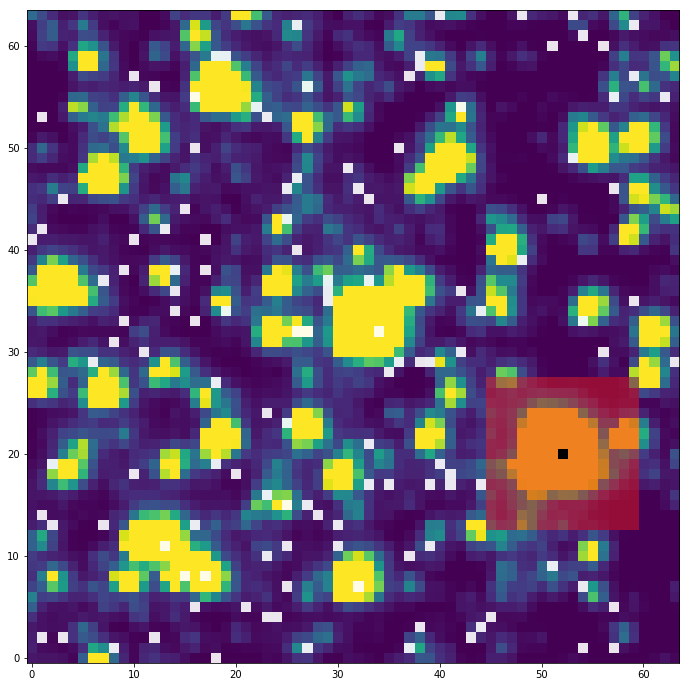

In [432]:
plt.figure(figsize=(12, 12))
first_image = cpm.im_fluxes[0,:,:]
plt.imshow(first_image, origin="lower",
           vmin=np.percentile(first_image, 10), vmax=np.percentile(first_image, 90))
plt.imshow(cpm.excluded_pixels_mask, origin="lower", cmap="Set1", alpha=0.5)
plt.imshow(cpm.target_pixel_mask, origin="lower", cmap="binary_r", alpha=1.0)
plt.imshow(cpm.predictor_pixels_mask, origin="lower", cmap="binary", alpha=0.9)

In [433]:
cpm.train(1e4)

True
Optimization terminated successfully.


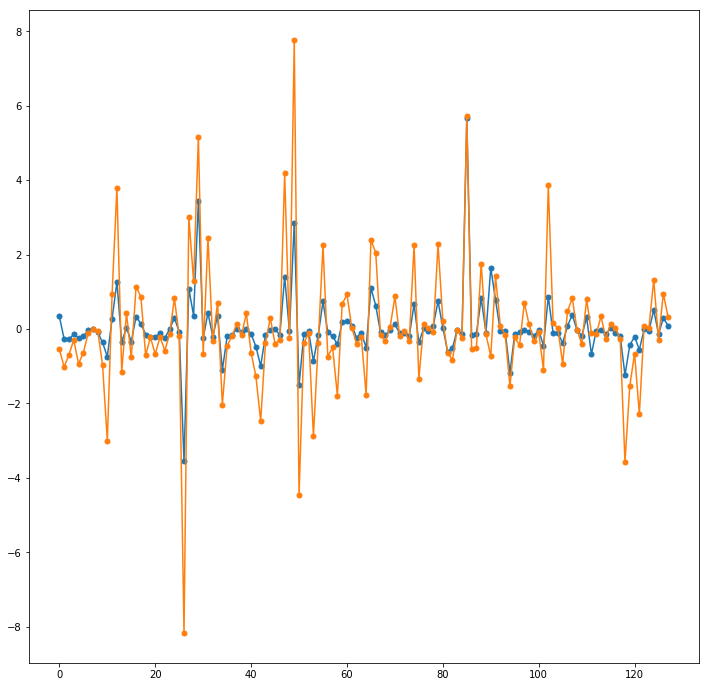

In [434]:
plt.figure(figsize=(12, 12))
plt.plot(cpm.fit.x, ".-", markersize=10)
plt.plot(cpm.lsq_params, ".-", markersize=10)

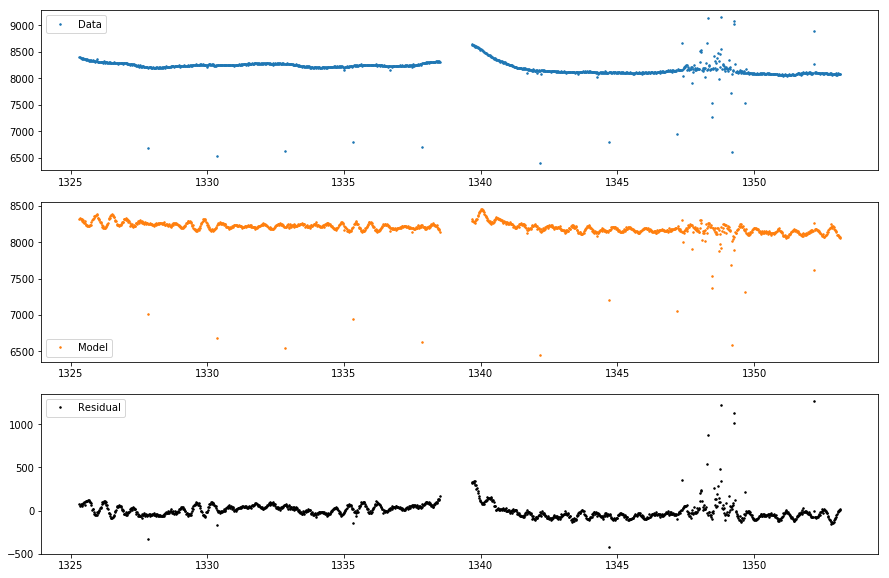

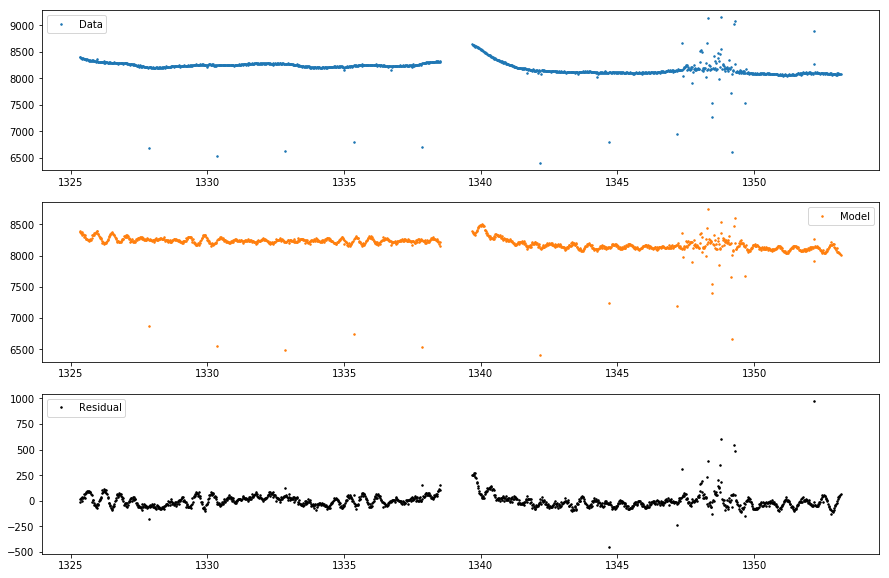

In [435]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

data = cpm.target_fluxes
model = cpm.prediction
res = data - model
axs[0].plot(cpm.time, data, ".", label="Data", markersize=3)
axs[1].plot(cpm.time, model, ".", label="Model", markersize=3, color="C1")
axs[2].plot(cpm.time, res, ".", label="Residual", markersize=3, color="k")
for i in range(3):
    axs[i].legend()
    
plt.show()

fig, axs = plt.subplots(3, 1, figsize=(15, 10))

data = cpm.target_fluxes
model = cpm.lsq_prediction
res = data - model
axs[0].plot(cpm.time, data, ".", label="Data", markersize=3)
axs[1].plot(cpm.time, model, ".", label="Model", markersize=3, color="C1")
axs[2].plot(cpm.time, res, ".", label="Residual", markersize=3, color="k")
for i in range(3):
    axs[i].legend()
    
plt.show()

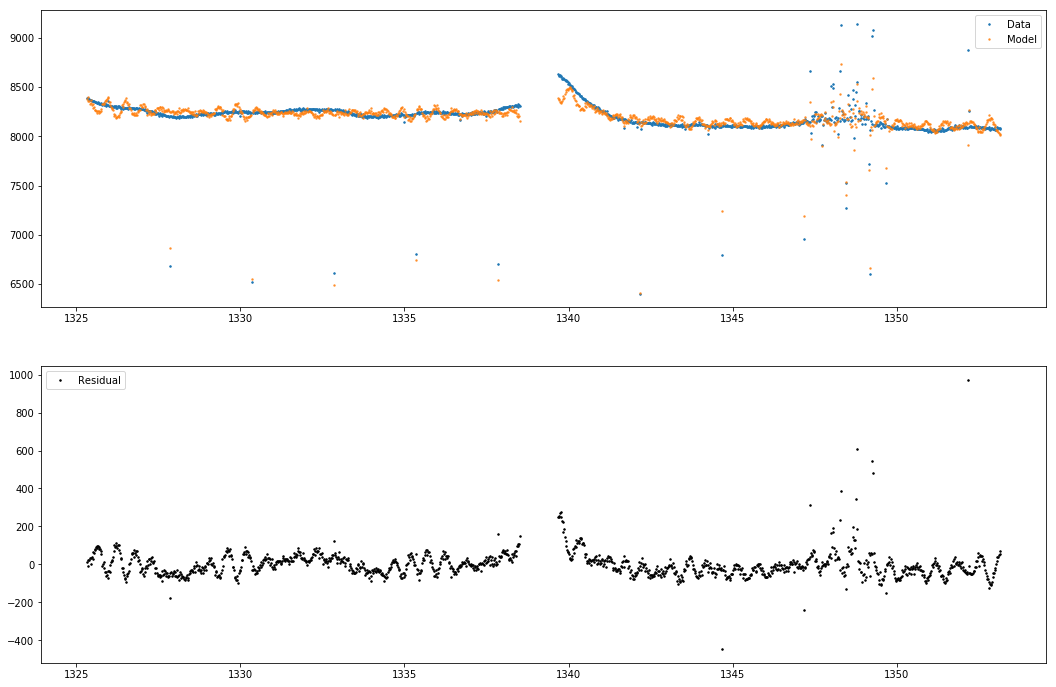

In [436]:
fig, axs = plt.subplots(2, 1, figsize=(18, 12))
axs[0].plot(cpm.time, data, ".", label="Data", markersize=3)
axs[0].plot(cpm.time, model, ".", label="Model", markersize=3, alpha=0.7, color="C1")
axs[1].plot(cpm.time, res, ".", label="Residual", markersize=3, color="k")

for i in range(2):
    axs[i].legend()

Text(0.5, 0, 'Coefficient')

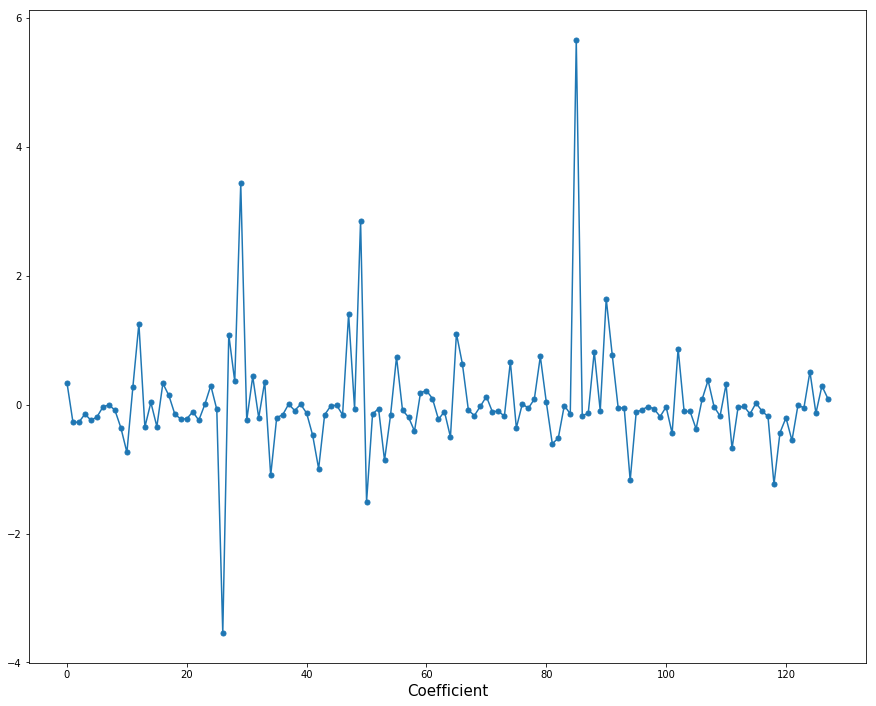

In [437]:
top_n_loc, top_n_mask = cpm.get_contributing_pixels(5)
plt.figure(figsize=(15, 12))
plt.plot(cpm.fit.x, ".-", markersize=10)
plt.xlabel("Coefficient", fontsize=15)

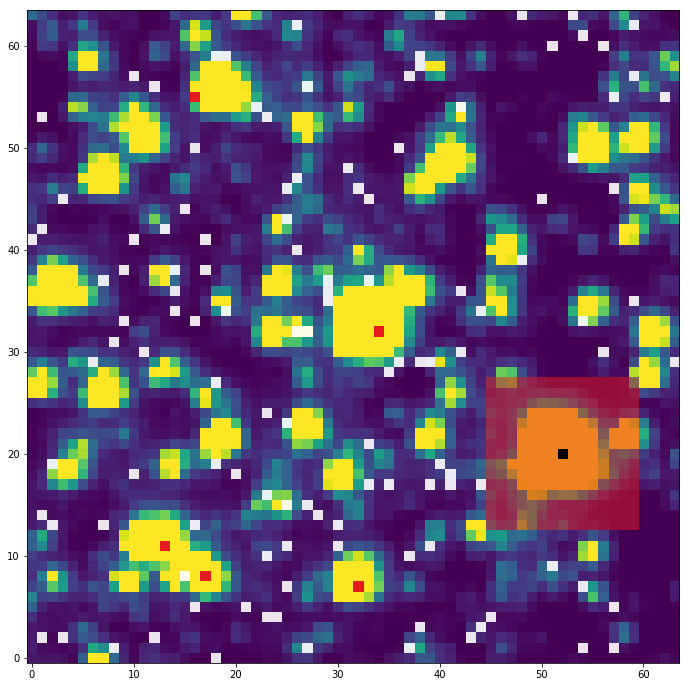

In [438]:
plt.figure(figsize=(12, 12))
first_image = cpm.im_fluxes[0,:,:]
plt.imshow(first_image, origin="lower",
           vmin=np.percentile(first_image, 10), vmax=np.percentile(first_image, 90))
plt.imshow(cpm.excluded_pixels_mask, origin="lower", cmap="Set1", alpha=0.5)
plt.imshow(cpm.target_pixel_mask, origin="lower", cmap="binary_r", alpha=1.0)
plt.imshow(cpm.predictor_pixels_mask, origin="lower", cmap="binary", alpha=0.9)
plt.imshow(top_n_mask, origin="lower", cmap="Set1")

In [215]:
cpm.get_contributing_pixels(10)

(10, 2)


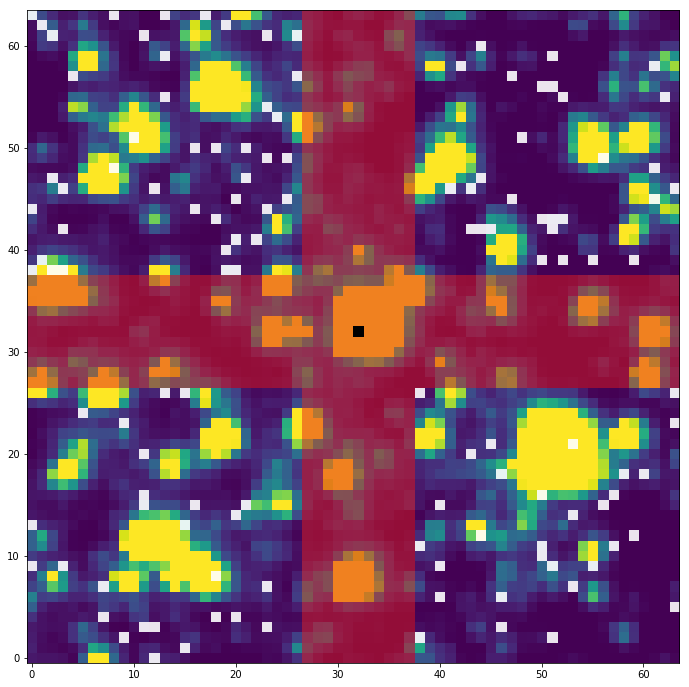

In [439]:
cpm_cross = CPM(fits_file)
cpm_cross.set_target(32, 32)
cpm_cross.set_exclusion(5, method="cross")
cpm_cross.set_predictor_pixels(128, method="random", seed=5)

plt.figure(figsize=(12, 12))
first_image = cpm_cross.im_fluxes[0,:,:]
plt.imshow(first_image, origin="lower",
           vmin=np.percentile(first_image, 10), vmax=np.percentile(first_image, 90))
plt.imshow(cpm_cross.excluded_pixels_mask, origin="lower", cmap="Set1", alpha=0.5)
plt.imshow(cpm_cross.target_pixel_mask, origin="lower", cmap="binary_r", alpha=1.0)
plt.imshow(cpm_cross.predictor_pixels_mask, origin="lower", cmap="binary", alpha=0.9)

True
Optimization terminated successfully.


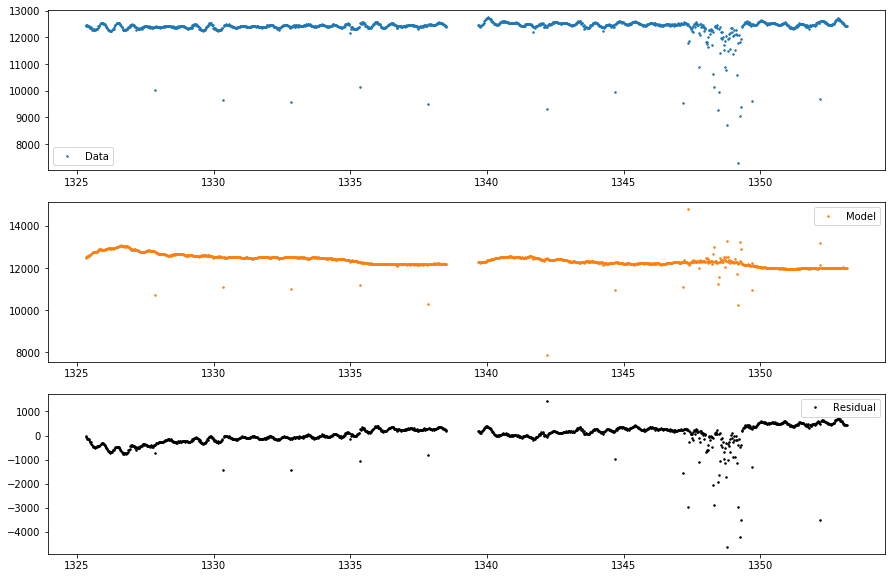

In [176]:
cpm_cross.train()

fig, axs = plt.subplots(3, 1, figsize=(15, 10))

data = cpm_cross.target_fluxes
model = cpm_cross.prediction
res = data - model
axs[0].plot(cpm_cross.time, data, ".", label="Data", markersize=3)
axs[1].plot(cpm_cross.time, model, ".", label="Model", markersize=3, color="C1")
axs[2].plot(cpm_cross.time, res, ".", label="Residual", markersize=3, color="k")
for i in range(3):
    axs[i].legend()

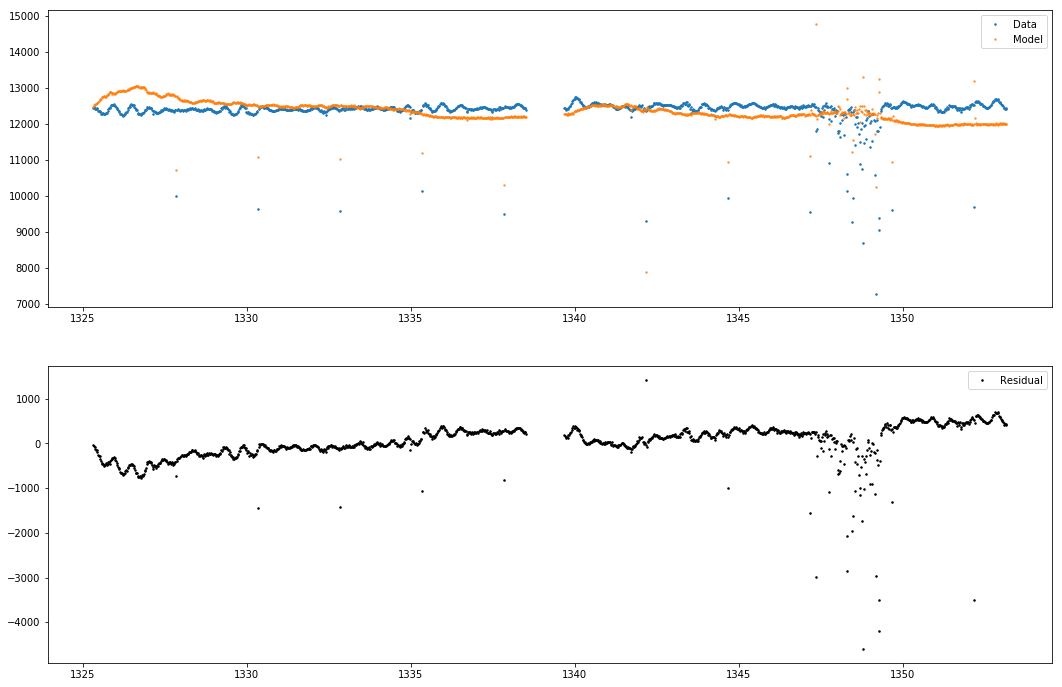

In [177]:
fig, axs = plt.subplots(2, 1, figsize=(18, 12))
axs[0].plot(cpm_cross.time, data, ".", label="Data", markersize=3)
axs[0].plot(cpm_cross.time, model, ".", label="Model", markersize=3, alpha=0.7, color="C1")
axs[1].plot(cpm_cross.time, res, ".", label="Residual", markersize=3, color="k")

for i in range(2):
    axs[i].legend()

Text(0.5, 0, 'Coefficient')

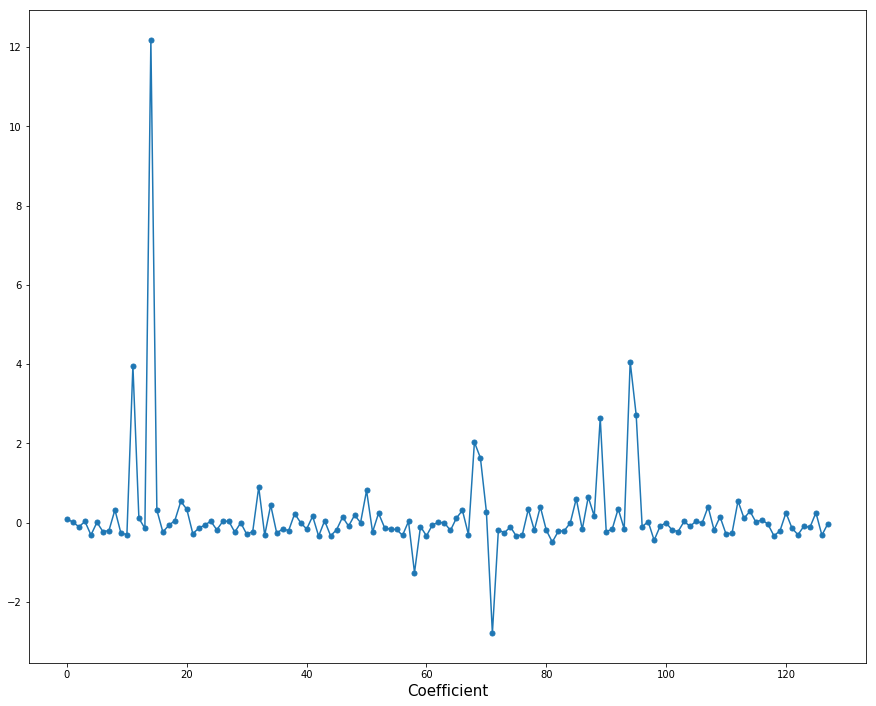

In [178]:
plt.figure(figsize=(15, 12))
plt.plot(cpm_cross.fit.x, ".-", markersize=10)
plt.xlabel("Coefficient", fontsize=15)

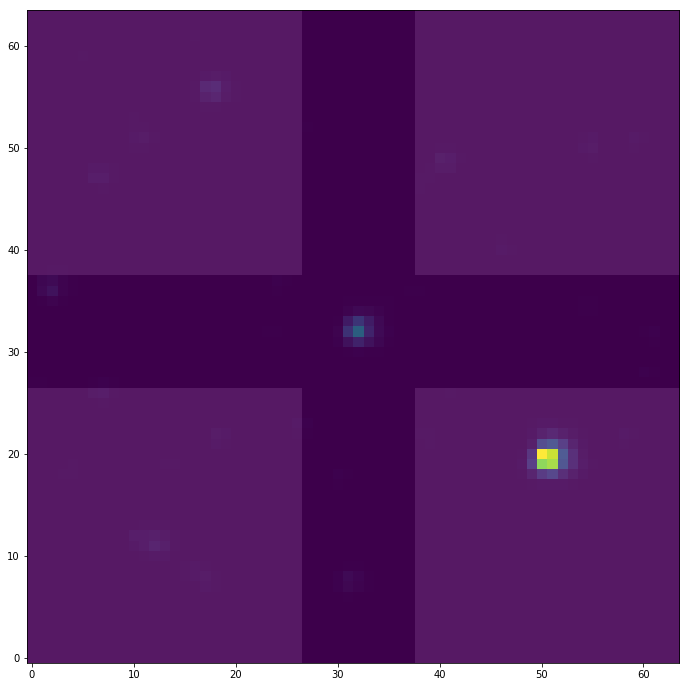

In [10]:
plt.figure(figsize=(12, 12))
# cpm.excluded_pixels_mask.mask
# first_image.shape
plt.imshow(first_image, origin="lower")
valid_to_choose = first_image*cpm.excluded_pixels_mask.mask
plt.imshow(valid_to_choose == 0, origin="lower", cmap="binary", alpha=0.1)
# valid_to_choose.tolist()

In [ ]:
cpm.excluded_pixels_mask

In [ ]:
grid = np.indices((3, 4))
# grid.shape
x = np.transpose(grid, (1, 2, 0))
x[(0,2)]

In [ ]:
i = np.array([[[0,0],[0,1],[0,2]],[[1,0],[1,1],[1,2]]])

In [ ]:
i[(0,1)]

In [ ]:
idx_grid = np.indices((64,64)).transpose(1, 2, 0)
idx_grid.shape
idx_list = np.arange(64*64)

In [ ]:
plt.imshow(cpm.excluded_pixels_mask.mask, cmap="binary")

In [ ]:
b = cpm.excluded_pixels_mask.mask.ravel()

In [ ]:
(idx_list[b]).shape

In [ ]:
x = np.arange(10)
x[2-3:0]

In [ ]:
np.min([2, 3])

In [191]:
x = np.arange(10)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [189]:
x[-4:]

array([6, 7, 8, 9])

In [1]:
def plot_lightcurves(cpm):
    fig, axs = plt.subplots(2, 1, figsize=(18, 12))
    data = cpm.target_fluxes
    model = cpm.lsq_prediction
    res = data - model
    
    axs[0].plot(cpm.time, data, ".", color="k", label="Data", markersize=3)
    axs[0].plot(cpm.time, model, ".", color="C3", label="Model", markersize=3, alpha=0.7)
    axs[1].plot(cpm.time, res, ".", label="Residual", markersize=3)

    for i in range(2):
        axs[i].legend(fontsize=15)
        
    plt.show()

def summary_plot(cpm, n):
    
    top_n_loc, top_n_mask = cpm.get_contributing_pixels(n)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 18))
    
    first_image = cpm.im_fluxes[0,:,:]
    axs[0].imshow(first_image, origin="lower",
           vmin=np.percentile(first_image, 10), vmax=np.percentile(first_image, 90))
    
    axs[1].imshow(first_image, origin="lower",
           vmin=np.percentile(first_image, 10), vmax=np.percentile(first_image, 90))
    axs[1].imshow(cpm.excluded_pixels_mask, origin="lower", cmap="Set1", alpha=0.5)
    axs[1].imshow(cpm.target_pixel_mask, origin="lower", cmap="binary_r", alpha=1.0)
    axs[1].imshow(cpm.predictor_pixels_mask, origin="lower", cmap="binary", alpha=0.9)
    
    axs[2].imshow(first_image, origin="lower",
           vmin=np.percentile(first_image, 10), vmax=np.percentile(first_image, 90))
    axs[2].imshow(cpm.excluded_pixels_mask, origin="lower", cmap="Set1", alpha=0.5)
    axs[2].imshow(cpm.target_pixel_mask, origin="lower", cmap="binary_r", alpha=1.0)
    axs[2].imshow(cpm.predictor_pixels_mask, origin="lower", cmap="binary", alpha=0.9)
    axs[2].imshow(top_n_mask, origin="lower", cmap="Set1")
    
    plt.show()
    
    fig, axs = plt.subplots(2, 1, figsize=(18, 8))
    data = cpm.target_fluxes
    model = cpm.lsq_prediction
    res = data - model
    
    axs[0].plot(cpm.time, data, ".", color="k", label="Data", markersize=3)
    axs[0].plot(cpm.time, model, ".", color="C3", label="Model", markersize=3, alpha=0.7)
    axs[1].plot(cpm.time, res, ".", label="Residual", markersize=3)

    for i in range(2):
        axs[i].legend()
    
    plt.show()

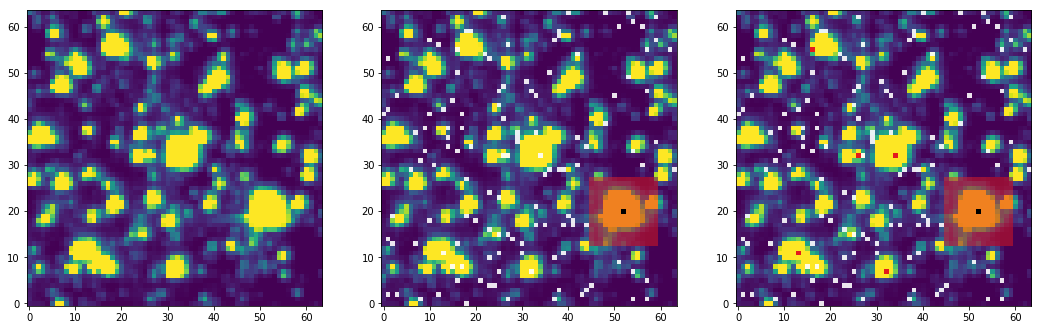

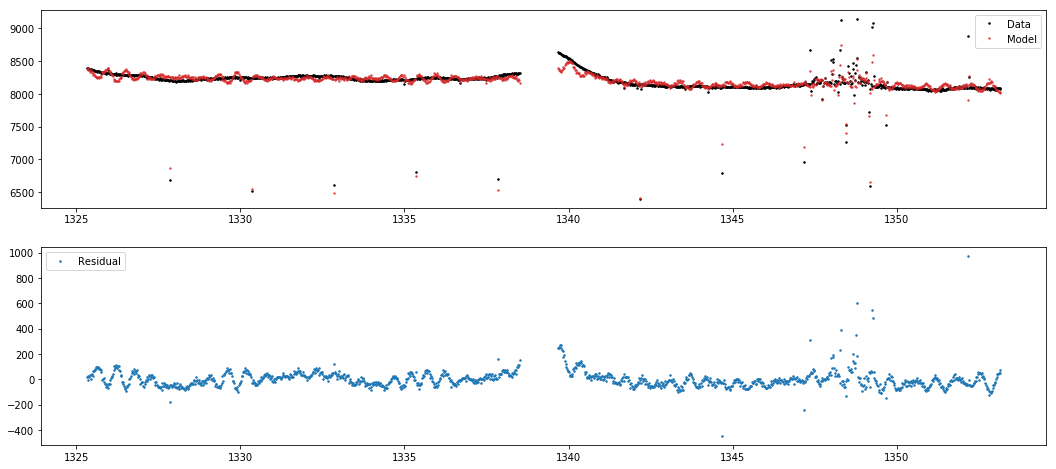

In [427]:
summary_plot(cpm, 5)
# plot_lightcurves(cpm)

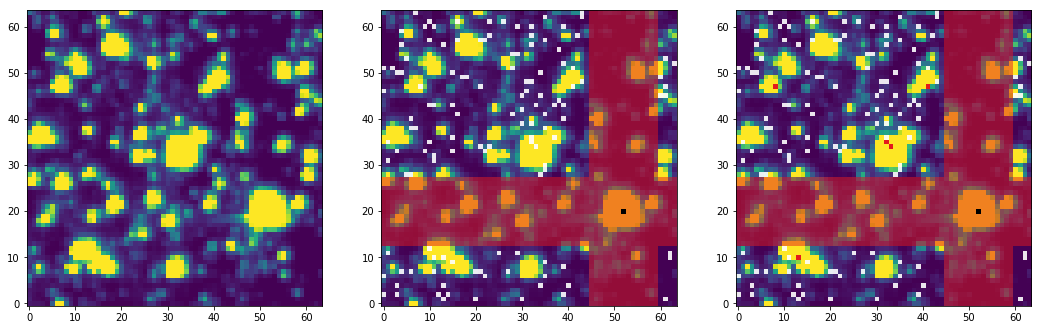

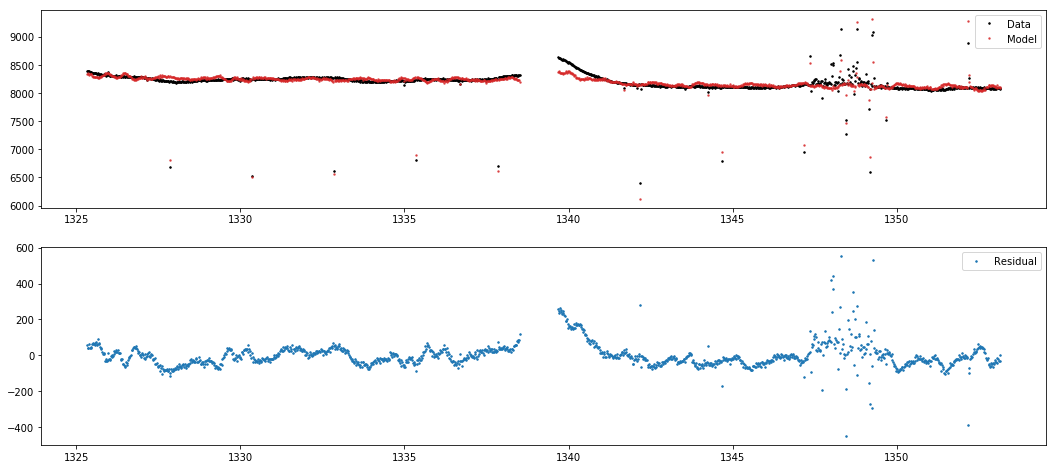

In [440]:
cross_bottom_right = CPM(fits_file)
# cpm.set_target(2, 32)  # random empty spot
cross_bottom_right.set_target(20, 52)  # bottom right 

cross_bottom_right.set_exclusion(7, method="cross")
cross_bottom_right.set_predictor_pixels(128, method="random", seed=2)

reg = 1e4
# cross_bottom_right.train(reg)
cross_bottom_right.lsq(reg)

summary_plot(cross_bottom_right, 5)

True
Optimization terminated successfully.


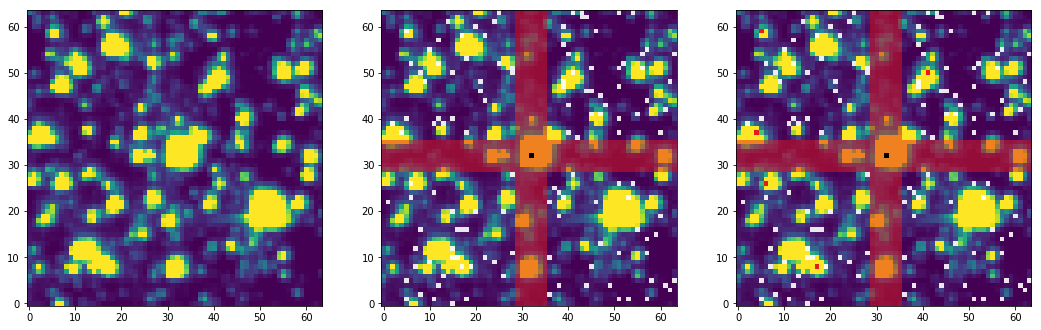

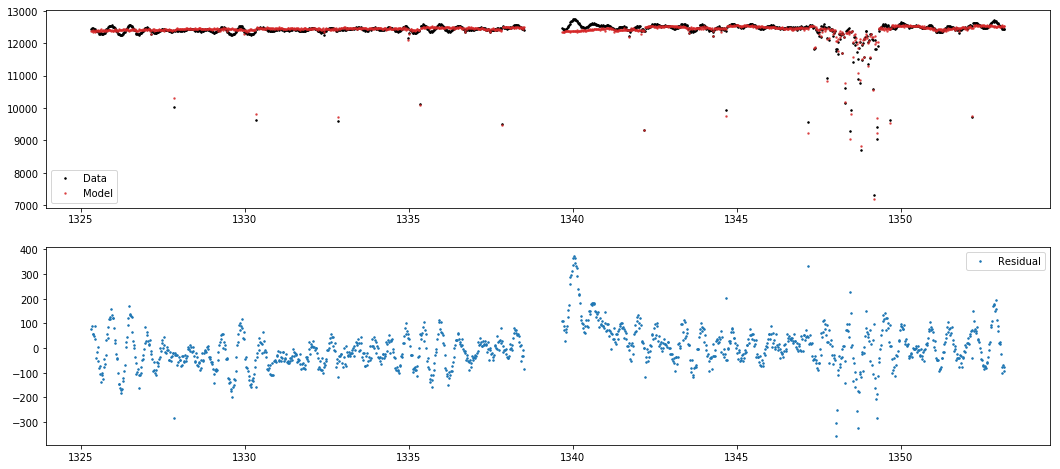

In [443]:
center_closest = CPM(fits_file)

center_closest.set_target(32, 32)

center_closest.set_exclusion(3, method="cross")
center_closest.set_predictor_pixels(128, method="random", seed=2)

center_closest.train(reg)
center_closest.lsq(reg)

summary_plot(center_closest, 5)

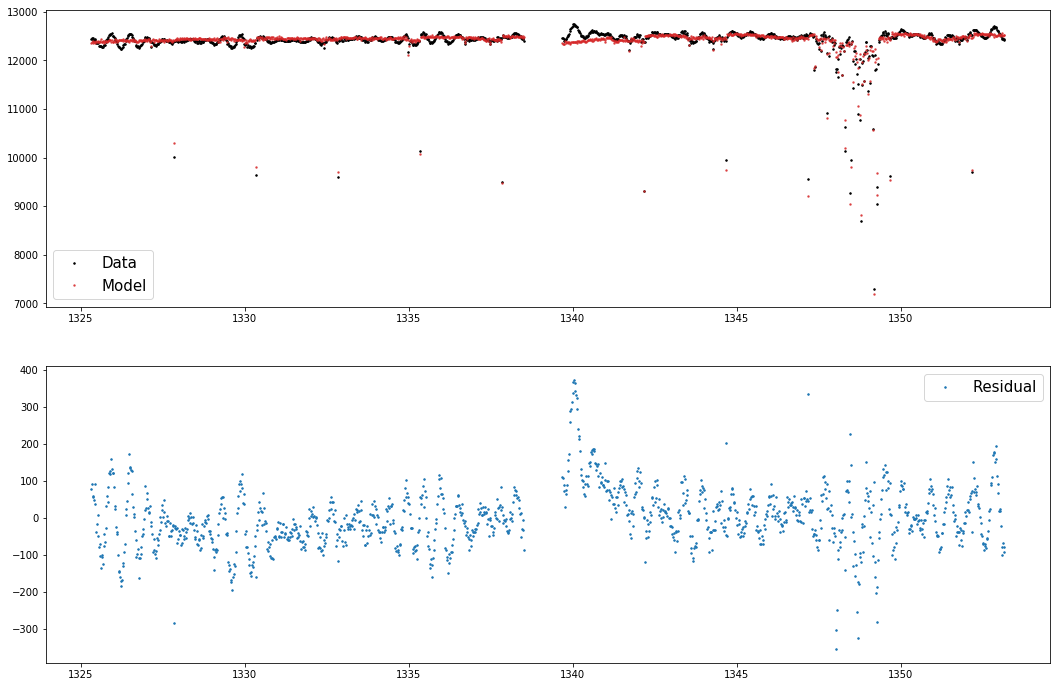

In [444]:
plot_lightcurves(center_closest)

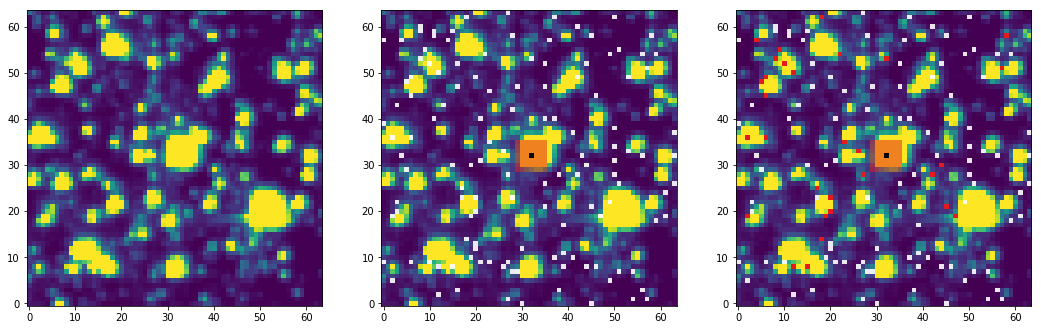

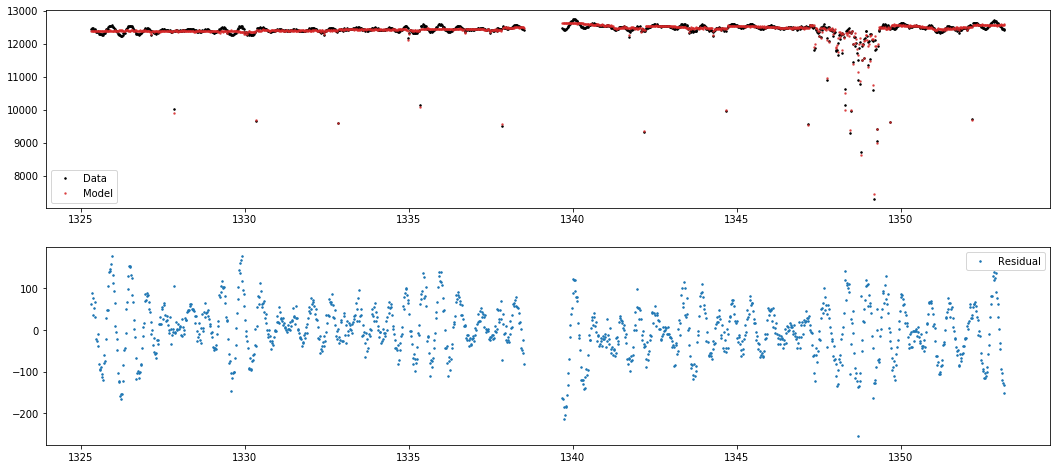

In [459]:
c = CPM(fits_file)

c.set_target(32, 32)

c.set_exclusion(3, method="closest")
c.set_predictor_pixels(128, method="random", seed=2)

# center_closest.train(reg)
c.lsq(reg)

summary_plot(c, 30)

# Did we really just fit and remove the high jitter around 1347-1349???

In [2]:
c = CPM(fits_file)

c.set_target(32, 32)

c.set_exclusion(5, method="cross")
c.set_predictor_pixels(128, method="random", seed=10)

# center_closest.train(reg)
c.lsq(reg)

summary_plot(c, 10)

# Did we really just fit and remove the high jitter around 1347-1349???

NameError: name 'CPM' is not defined